In [22]:
import datasets as ds
import utils as ut
import models as md

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import ShuffleSplit

sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Section 1: Auditing with repsect to stereotypes 

In [10]:
dataset = ds.Dataset("nels")
dataset.split_train_test()
print(dataset.x_train.shape, dataset.x_test.shape)

total students 12144
Limiting entries to two racial groups 3 n=1041 and 4 n=7908
remaining students 8949
(6264, 812) (1343, 812)


In [29]:
# base predictor
clf = LogisticRegression(max_iter=500)
clf.fit(dataset.x_train, dataset.y_train)

p = clf.predict_proba(dataset.x_test)[:, 1]
p_acc = accuracy_score(dataset.y_test, p > 0.5)

mask = dataset.g_test == 1
white_acc = accuracy_score(dataset.y_test[mask], p[mask] > 0.5)
black_acc = accuracy_score(dataset.y_test[~mask], p[~mask] > 0.5)

print(
    f"base clf acc: {p_acc:.3f} male acc: {white_acc:.3f} female acc: {black_acc:.3f}"
)

base clf acc: 0.831 male acc: 0.831 female acc: 0.834


In [30]:
# interpret features
g_clf = LogisticRegression(max_iter=500)
g_clf.fit(dataset.x_train, dataset.g_train)

abs_coeff = np.abs(g_clf.coef_.round(1)).flatten()
coeff = g_clf.coef_.round(1).flatten()
coeff_sorted = coeff[np.argsort(abs_coeff)[::-1]]
abs_coeff_sorted = abs_coeff[np.argsort(abs_coeff)[::-1]]
print(coeff_sorted[:10])
dataset.x_labels[np.argsort(abs_coeff)[::-1][:10]]

[ 1.4  1.2 -1.2 -1.1  1.1  1.   1.   0.9 -0.9 -0.9]


Index(['G8MINOR_0', 'F22XSSTD', 'F2RHSCG2', 'G8MINOR_7', 'G8REGON_4',
       'F22XMSTD', 'F12XSSTD', 'F2ROSO_C', 'G8REGON_3', 'G8MINOR_6'],
      dtype='object')

Top 10 Contributers to race: 
- 'G8MINOR_0' # PERCENT MINORITY IN SCHOOL
- 'F22XSSTD' # SCIENCE STANDARDIZED SCORE
- 'F12XSSTD' #SCIENCE STANDARDIZED SCORE
- 'G8MINOR_7'  # PERCENT MINORITY IN SCHOOL
- 'F2ROSO_C' #UNITS IN OTHER SOC. STUDIES (NAEP)
- 'G8REGON_3' #COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'G8MINOR_6' # PERCENT MINORITY IN SCHOOL
- 'G8REGON_4' # COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'F22XMSTD' #MATHEMATICS STANDARDIZED SCORE 
- 'G8MINOR_4' #  PERCENT MINORITY IN SCHOOL

In [13]:
standarized_test_features = [
    "F12XRSTD",
    "F12XMSTD",
    "F12XSSTD",
    "F12XHSTD",
    "F22XRSTD",
    "F22XMSTD",
    "F22XSSTD",
    "F22XHSTD",
    "BY2XRSTD",
    "BY2XMSTD",
    "BY2XSSTD",
    "BY2XHSTD",
]
freelunch_minority = [
    "G8MINOR_0",
    "G8MINOR_1",
    "G8MINOR_2",
    "G8MINOR_3",
    "G8MINOR_4",
    "G8MINOR_5",
    "G8MINOR_6",
    "G8MINOR_7",
    "G8MINOR_998",
    "G8MINOR_999",
    "G8LUNCH_0",
    "G8LUNCH_1",
    "G8LUNCH_2",
    "G8LUNCH_3",
    "G8LUNCH_4",
    "G8LUNCH_5",
    "G8LUNCH_6",
    "G8LUNCH_7",
    "G8LUNCH_998",
    "G8LUNCH_999",
]

In [14]:
# use 64 dim
n_dim = 32
pca = PCA(n_components=n_dim)
dataset.x_pca_train = pca.fit_transform(dataset.x_train)
dataset.x_pca_test = pca.transform(dataset.x_test)


def find_means(features: np.array, group_labels: np.array):
    ## assume group labels are 1 and 0
    group1 = features[group_labels]
    group2 = features[~group_labels]
    # print(group1.mean(axis=0).shape)
    means = np.stack([group1.mean(axis=0), group2.mean(axis=0)])
    return means

In [31]:
# stereotype predictors:
# 1) overall pg
all_pg_clf = LogisticRegression(max_iter=500)
all_pg_clf.fit(dataset.x_train, dataset.g_train)
all_pg = all_pg_clf.predict_proba(dataset.x_test)[:, 1]

# 2) harmful features
feature_indices = np.array(
    [
        list(dataset.x_labels).index(key)
        for key in freelunch_minority
        if key in dataset.x_labels
    ]
)
dataset.x_harmful_train = dataset.x_train[:, feature_indices]
dataset.x_harmful_test = dataset.x_test[:, feature_indices]

test_pg_clf_base = LogisticRegression(max_iter=500)
test_pg_clf_base = test_pg_clf_base.fit(dataset.x_harmful_train, dataset.g_train)
test_pg_clf = md.HarmfulFeaturesClassifier(
    base_clf=test_pg_clf_base, feature_ind=feature_indices
)
test_pg = test_pg_clf.predict_proba(dataset.x_test)[:, 1]
print(test_pg.mean())

# 3) clustering
cntr = find_means(dataset.x_pca_train, dataset.g_train)
cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)
cluster_pg = cluster_pg_clf.predict_proba(dataset.x_test)[:, 1]

0.8831953558585398


In [16]:
# evaluate stereotype predictors
# clf

results = {}
p = clf.predict_proba(dataset.x_test)[:, 1]
for pg, name in zip([all_pg, test_pg, cluster_pg], ["all_pg", "harm_pg", "cluster_pg"]):
    print(name)
    # group prediction accuracy
    print(f"acc {accuracy_score(dataset.g_test, pg>0.5):.3f}")
    print("cov(y, pg)", ut.emp_cov(dataset.y_test, pg))
    print("corr(y, pg)", stats.pearsonr(dataset.y_test, pg))
    print("cov(p, pg)", ut.emp_cov(p, pg))
    print("corr(p, pg)", stats.pearsonr(p, pg))
    results[name] = {}
    results[name]["DP"] = ut.emp_cov(p, pg)
    results[name]["DP_corr"] = stats.pearsonr(p, pg)

    mask = dataset.y_test == 1
    print("cov(p, pg | y=1)", ut.emp_cov(p[mask], pg[mask]))
    print("corr(p, pg | y=1)", stats.pearsonr(p[mask], pg[mask]))
    results[name]["EO"] = ut.emp_cov(p[mask], pg[mask])
    results[name]["EO_corr"] = stats.pearsonr(p[mask], pg[mask])

    results[name]["MA"] = np.abs(ut.emp_cov(p, pg) - ut.emp_cov(dataset.y_test, pg))

all_pg
acc 0.908
cov(y, pg) 0.018279171936434604
corr(y, pg) PearsonRResult(statistic=np.float64(0.14410099848590305), pvalue=np.float64(1.1350988979164644e-07))
cov(p, pg) 0.015579639693589121
corr(p, pg) PearsonRResult(statistic=np.float64(0.1637802440776078), pvalue=np.float64(1.567435713999778e-09))
cov(p, pg | y=1) 0.006660881287347332
corr(p, pg | y=1) PearsonRResult(statistic=np.float64(0.1276016312845891), pvalue=np.float64(0.004383223212446546))
harm_pg
acc 0.911
cov(y, pg) 0.013414631770374842
corr(y, pg) PearsonRResult(statistic=np.float64(0.14599879546841757), pvalue=np.float64(7.690148653626196e-08))
cov(p, pg) 0.011256541148767962
corr(p, pg) PearsonRResult(statistic=np.float64(0.163368797489877), pvalue=np.float64(1.7238595179360417e-09))
cov(p, pg | y=1) 0.005803916273265265
corr(p, pg | y=1) PearsonRResult(statistic=np.float64(0.14598188491774905), pvalue=np.float64(0.0010994717864576996))
cluster_pg
acc 0.844
cov(y, pg) 0.005547332924725184
corr(y, pg) PearsonRResult(

## Demographic Parity

In [ ]:
DP_plot = []
# DP Post Processing
dataset = dataset

cv = ShuffleSplit(
    n_splits=5, test_size=0.1, random_state=42
)  # change the number of splits here

i = 0

for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)

    # 1) stereotype associations
    all_pg_clf = LogisticRegression()
    all_pg_clf.fit(x_train_sub, g_train_sub)

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression()
    test_pg_clf_base = test_pg_clf_base.fit(
        x_train_sub[:, feature_indices], g_train_sub
    )
    test_pg_clf = md.HarmfulFeaturesClassifier(
        base_clf=test_pg_clf_base, feature_ind=feature_indices
    )

    # 2c) clustering
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)

    pg_dict = {
        "all_pg": all_pg_clf,
        "harm_pg": test_pg_clf,
        "cluster_pg": cluster_pg_clf,
    }

    prev_results = ut.results_summary(
        p=clf.predict_proba(dataset.x_test)[:, 1],
        pg_dict=pg_dict,
        x=dataset.x_test,
        y=dataset.y_test,
        g=dataset.g_test,
    )

    clfs = [
        ([all_pg_clf], r"$\hat{p}_g^{(all)}$"),
        ([test_pg_clf], r"$\hat{p}_g^{(harm)}$"),
        ([cluster_pg_clf], r"$\hat{p}_g^{(FCM)}$"),
        (
            [all_pg_clf, test_pg_clf, cluster_pg_clf],
            r"$(\hat{p}_g^{(all)}, \hat{p}_g^{(harm)}, \hat{p}_g^{(FCM)})$",
        ),
    ]

    for clf_list, clf_list_name in clfs:
        # 2. Refit models
        clf = LogisticRegression()
        clf.fit(x_train_sub, y_train_sub)

        if clf_list_name == r"$\hat{p}_g^{(all)}$":
            for key in pg_dict.keys():
                DP_plot.append(
                    {
                        "eval_pg": key,
                        "intervention_pg": "None",
                        "value": prev_results[f"cov(p, {key})"],
                        "run": i,
                        "acc": prev_results["accuracy"],
                    }
                )

        c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
        md.fit_dp_pg_multi(
            x=x_train_sub, multi_clf=c_post_processed, alpha=1e-4, max_iter=10
        )  # change the number of iterations

        results = ut.results_summary(
            p=c_post_processed.predict_proba_1d(dataset.x_test),
            pg_dict=pg_dict,
            x=dataset.x_test,
            y=dataset.y_test,
            g=dataset.g_test,
        )
        for key in pg_dict.keys():
            DP_plot.append(
                {
                    "eval_pg": key,
                    "intervention_pg": f"DP wrt. {clf_list_name}",
                    "value": results[f"cov(p, {key})"],
                    "acc": results["accuracy"],
                    "run": i,
                }
            )

In [27]:
plot_df = pd.DataFrame(DP_plot)
plot_map = {
    "all_pg": r"$\hat{p}_g^{(all)}$",
    "harm_pg": r"$\hat{p}_g^{(harm)}$",
    "cluster_pg": r"$\hat{p}_g^{(FCM)}$",
}
plot_df["eval_pg"] = plot_df["eval_pg"].map(plot_map)
acc_dict = plot_df.groupby("intervention_pg")["acc"].mean().to_dict()
plot_df.to_csv("results/nels_dp_v2.csv")

DP wrt. $\hat{p}_g^{(all)}$
DP wrt. $\hat{p}_g^{(harm)}$
DP wrt. $\hat{p}_g^{(FCM)}$
DP wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


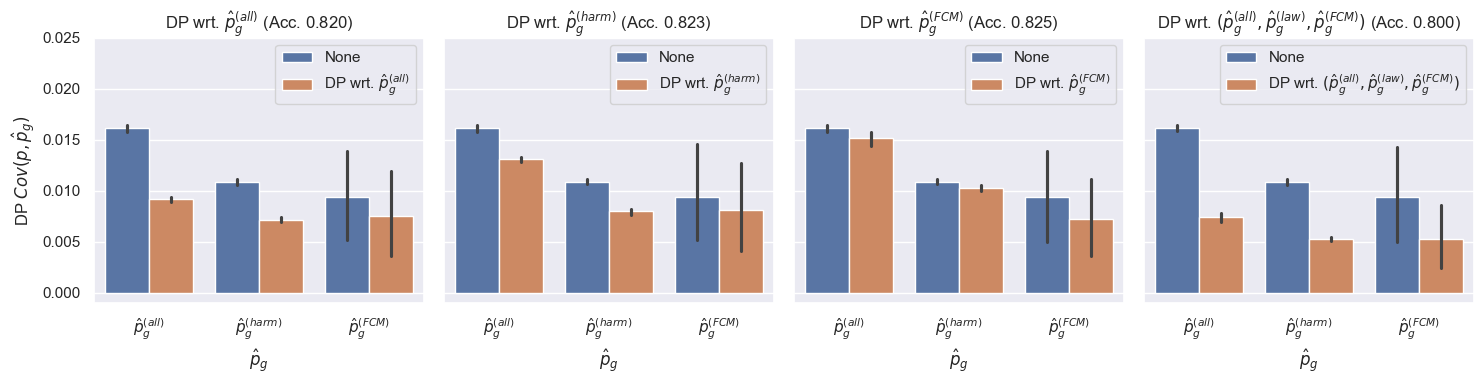

In [28]:
plot_df["abs_value"] = plot_df["value"].map(np.abs)

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df["intervention_pg"].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df["intervention_pg"].isin([key, "None"])]
    sns.barplot(
        data=subplot_df, x="eval_pg", y="abs_value", hue="intervention_pg", ax=ax
    )
    ax.legend(title=None, loc="upper right")
    ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r"$\hat{p}_g$")
    ax.set_ylabel(r"DP $Cov(p, \hat{p}_g)$")
    ax.set_title(f"{key} (Acc. {acc_dict[key]:.3f})")

plt.tight_layout()
plt.savefig("img/nels/dp_all_nels.pdf")

## Equal Opportunity

In [ ]:
# DP Post Processing
EO_plot = []

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
acc_list = []

i = 0
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression()
    test_pg_clf_base = test_pg_clf_base.fit(
        x_train_sub[:, feature_indices], g_train_sub
    )
    test_pg_clf = md.HarmfulFeaturesClassifier(
        base_clf=test_pg_clf_base, feature_ind=feature_indices
    )

    # 2c) clustering
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)

    pg_dict = {
        "all_pg": all_pg_clf,
        "harm_pg": test_pg_clf,
        "cluster_pg": cluster_pg_clf,
    }

    prev_results = ut.results_summary(
        p=clf.predict_proba(dataset.x_test)[:, 1],
        pg_dict=pg_dict,
        x=dataset.x_test,
        y=dataset.y_test,
        g=dataset.g_test,
    )

    clfs = [
        ([all_pg_clf], r"$\hat{p}_g^{(all)}$"),
        ([test_pg_clf], r"$\hat{p}_g^{(harm)}$"),
        ([cluster_pg_clf], r"$\hat{p}_g^{(FCM)}$"),
        (
            [all_pg_clf, test_pg_clf, cluster_pg_clf],
            r"$(\hat{p}_g^{(all)}, \hat{p}_g^{(harm)}, \hat{p}_g^{(FCM)})$",
        ),
    ]

    for clf_list, clf_list_name in clfs:

        if clf_list_name == r"$\hat{p}_g^{(all)}$":
            for key in pg_dict.keys():
                EO_plot.append(
                    {
                        "eval_pg": key,
                        "intervention_pg": "None",
                        "value": np.abs(prev_results[f"cov(p, {key} |y=1)"]),
                        "run": i,
                        "acc": prev_results["accuracy"],
                    }
                )

        eo_clf = md.EOClf(base_clf=clf, pg_clf_list=clf_list)
        eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)

        results = ut.results_summary(
            p=eo_clf.predict_proba(dataset.x_test)[:, 1],
            pg_dict=pg_dict,
            x=dataset.x_test,
            y=dataset.y_test,
            g=dataset.g_test,
        )
        for key in pg_dict.keys():
            EO_plot.append(
                {
                    "eval_pg": key,
                    "intervention_pg": f"EO wrt. {clf_list_name}",
                    "value": np.abs(results[f"cov(p, {key} |y=1)"]),
                    "acc": results["accuracy"],
                    "run": i,
                }
            )

EO wrt. $\hat{p}_g^{(all)}$
EO wrt. $\hat{p}_g^{(harm)}$
EO wrt. $\hat{p}_g^{(FCM)}$
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


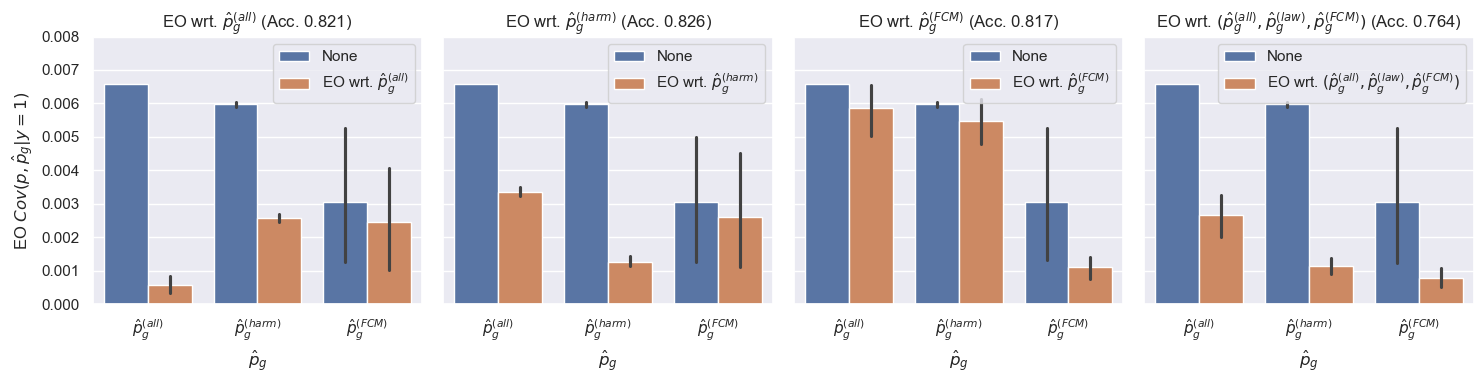

In [54]:
plot_df = pd.DataFrame(EO_plot)
plot_map = {
    "all_pg": r"$\hat{p}_g^{(all)}$",
    "harm_pg": r"$\hat{p}_g^{(harm)}$",
    "cluster_pg": r"$\hat{p}_g^{(FCM)}$",
}
plot_df["eval_pg"] = plot_df["eval_pg"].map(plot_map)
acc_dict = plot_df.groupby("intervention_pg")["acc"].mean().to_dict()

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df["intervention_pg"].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df["intervention_pg"].isin([key, "None"])]
    sns.barplot(data=subplot_df, x="eval_pg", y="value", hue="intervention_pg", ax=ax)
    ax.legend(title=None, loc="upper right")
    ax.set_ylim(-0.00, 0.008)
    ax.set_xlabel(r"$\hat{p}_g$")
    ax.set_ylabel(r"EO $Cov(p, \hat{p}_g |y=1)$")
    ax.set_title(f"{key} (Acc. {acc_dict[key]:.3f})")

plt.tight_layout()
plt.savefig("img/nels/eo_all_nels.pdf")